# Práctica Final: detección de mensajes troll

## Ejemplo de solución.

**Disclaimer.** Existen distintas formas de resolver el ejercicio y todas se considerarán correctas siempre que el modelo se entrene y despliegue acorde a lo esperado.

En los recientes años, Twitch no sólo ha surgido como un pionero en la comunicación moderna, sino también como un sitio donde las nuevas generaciones pasan el tiempo ver a otros jovenes haciendo cosas por internet. Esta plataforma, rica en interactividad, permite a los usuarios compartir sus pensamientos en tiempo real y después de las transmisiones. Sin embargo, entre las voces genuinas, algunas buscan dañar con comentarios ofensivos.

Pero hoy, nos embarcamos en una misión inspiradora: diseñar una Inteligencia Artificial que pueda identificar y neutralizar estos mensajes tóxicos. A lo largo de esta práctica, no solo entrenaremos un modelo de Deep Learning avanzado, sino que también lo implementaremos para inferencias en batch, estableciendo un nuevo estándar en la industria.

# Configuración de nuestro proyecto en GCP


In [1]:
PROJECT_ID = "big-data-mlops" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [2]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''


Creamos el bucket mediante la consola y una vez creado lo indicamos en la variable:

In [3]:
BUCKET_NAME = "masterclass-despliegue-kc-practica-nye" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [4]:
! gsutil ls -al gs://$BUCKET_NAME

   2756023  2023-09-16T11:06:25Z  gs://masterclass-despliegue-kc-practica-nye/data.json#1694862385654401  metageneration=1
                                 gs://masterclass-despliegue-kc-practica-nye/beam-temp/
                                 gs://masterclass-despliegue-kc-practica-nye/model/
                                 gs://masterclass-despliegue-kc-practica-nye/transformed_data/
TOTAL: 1 objects, 2756023 bytes (2.63 MiB)


# Entrenamiento e inferencia en Batch

## Preparación

Para esta primera parte se va a utilizar [Tweets Dataset for Detection of Cyber-Trolls](https://www.kaggle.com/dataturks/dataset-for-detection-of-cybertrolls). El objetivo es desarrollar un clasificador binario para detectar si el mensaje recibido es troll (1) o no (0). **Las métricas obtenidas del entrenamiento y la inferencia no se tendrán en cuenta para la evaluación de la práctica, la importancia está en la arquitectura de la solución**, es decir, lo importante no es que nuestro modelo detecte correctamente los tweets de trolls si no que funcione y sea capaz de hacer inferencias.


A continuación, se van a subir los datos de entrenamiento al bucket del proyecto que se haya creado. **Importante:** crea el bucket en una única región. Os dejo disponibilizado el dataset en un bucket de acceso público:

In [5]:
%pip install gdown
! gdown "1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr"

Downloading...
From: https://drive.google.com/uc?id=1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr
To: /content/dataset-cybertrolls.json
100% 2.76M/2.76M [00:00<00:00, 12.9MB/s]


Ahora se crea el directorio dónde vas a desarrollar esta primera parte de la práctica.

In [6]:
%mkdir /content/batch

Se establece el directorio de trabajo que hemos creado.

In [7]:
import os

# Set the working directory to the sample code directory
%cd /content/batch

WORK_DIR = os.getcwd()

/content/batch


Ahora se descargarán los datos en el workspace de Colab para trabajar en local.

In [8]:
! gdown "1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr"
! mv dataset-cybertrolls.json dataset.json

Downloading...
From: https://drive.google.com/uc?id=1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr
To: /content/batch/dataset-cybertrolls.json
100% 2.76M/2.76M [00:00<00:00, 16.8MB/s]


Se establecen las dependencias que se usarán en la práctica. Se pueden añadir y quitar las dependencias que no se usen o viceversa.

In [4]:
%%writefile requirements.txt
apache-beam[gcp]
tensorflow
gensim
fsspec==0.8.4
gcsfs==0.7.1
numpy

Overwriting requirements.txt


Instalamos las dependencias. **No olvides reiniciar el entorno al instalar y establecer las variables y credenciales de GCP al arrancar.**

In [10]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.3/671.3 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
! pip install apache-beam[gcp]

In [2]:
# Nos aseguramos que nuestras variables de entorno no hayan desaparecido al reiniciar el kernel

PROJECT_ID = "big-data-mlops" #@param {type:"string"}
! gcloud config set project $PROJECT_ID
BUCKET_NAME = "masterclass-despliegue-kc-practica-nye" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Bucket: {BUCKET_NAME}")

%cd /content/batch
!ls

import os
WORK_DIR = os.getcwd()

Updated property [core/project].
Project: big-data-mlops
Region: europe-west1
Bucket: masterclass-despliegue-kc-practica-nye
/content/batch
dataset.json  requirements.txt


## Primer ejercicio

Desarrollar un pipeline de preprocesamiento utilizando Apache Beam para generar datos de train, eval y test para los datos proporcionados anteriormente. Requisitos:

- Proporcionar dos modos de ejecución: `train` y `test`
- Soportar ejecuciones en local con `DirectRunner` y ejecuciones en Dataflow usando `DataFlowRunner`.

In [5]:
%%writefile preprocess.py

#
# Licensed to the Apache Software Foundation (ASF) under one or more
# contributor license agreements.  See the NOTICE file distributed with
# this work for additional information regarding copyright ownership.
# The ASF licenses this file to You under the Apache License, Version 2.0
# (the "License"); you may not use this file except in compliance with
# the License.  You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# pytype: skip-file

from __future__ import absolute_import

import argparse
import logging
import re
import os
import json
import random

from past.builtins import unicode

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.coders.coders import Coder
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions, DirectOptions

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download("stopwords")

# CLEANING
STOP_WORDS = stopwords.words("english")
STEMMER = SnowballStemmer("english")
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


class ExtractColumnsDoFn(beam.DoFn):
    def process(self, element):
        # json.loads() gets json object into a python dictionary
        element_dict = json.loads(element)

        #get text and troll label
        text = element_dict['content']
        troll_label = element_dict['annotation']['label'][0]

        # capture text, troll label
        yield text, troll_label # we need item in 1st position of the list returned


class PreprocessColumnsTrainFn(beam.DoFn):
    def process_label(self, label):
        label = int(label)
        if label == 1:
            return "TROLL"
        elif label == 0:
            return "NO TROLL"
        else:
            return "NA"

    def process_text(self, text):
        # Remove link,user and special characters
        stem = False
        text = re.sub(TEXT_CLEANING_RE, " ", str(text).lower()).strip()
        tokens = []
        for token in text.split():
            if token not in STOP_WORDS:
                if stem:
                    tokens.append(STEMMER.stem(token))
                else:
                    tokens.append(token)
        return " ".join(tokens)

    def process(self, element):
        processed_text = self.process_text(element[0])
        processed_label = self.process_label(element[1])
        yield f"{processed_text}, {processed_label}"


class CustomCoder(Coder):
    """A custom coder used for reading and writing strings"""

    def __init__(self, encoding: str):
        # latin-1
        # iso-8859-1
        self.enconding = encoding

    def encode(self, value):
        return value.encode(self.enconding)

    def decode(self, value):
        return value.decode(self.enconding)

    def is_deterministic(self):
        return True


def run(argv=None, save_main_session=True):

    """Main entry point; defines and runs the wordcount pipeline."""

    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--work-dir", dest="work_dir", required=True, help="Working directory",
    )

    parser.add_argument(
        "--input", dest="input", required=True, help="Input dataset in work dir",
    )
    parser.add_argument(
        "--output",
        dest="output",
        required=True,
        help="Output path to store transformed data in work dir",
    )
    parser.add_argument(
        "--mode",
        dest="mode",
        required=True,
        choices=["Train", "Test"],
        help="Type of output to store transformed data",
    )

    known_args, pipeline_args = parser.parse_known_args(argv)

    # We use the save_main_session option because one or more DoFn's in this
    # workflow rely on global context (e.g., a module imported at module level).
    pipeline_options = PipelineOptions(pipeline_args)
    pipeline_options.view_as(SetupOptions).save_main_session = save_main_session
    pipeline_options.view_as(DirectOptions).direct_num_workers = 0

    # The pipeline will be run on exiting the with block.
    with beam.Pipeline(options=pipeline_options) as p:

        # Read the text file[pattern] into a PCollection.
        raw_data = p | "ReadTwitchData" >> ReadFromText(
            known_args.input, coder=CustomCoder("latin-1")
        )

        if known_args.mode == "Train":

            transformed_data = (
                raw_data
                | "ExtractColumns" >> beam.ParDo(ExtractColumnsDoFn())
                | "Preprocess" >> beam.ParDo(PreprocessColumnsTrainFn())
            )

            eval_percent = 20
            assert 0 < eval_percent < 100, "eval_percent must in the range (0-100)"
            train_dataset, eval_dataset = (
                transformed_data
                | "Split dataset"
                >> beam.Partition(
                    lambda elem, _: int(random.uniform(0, 100) < eval_percent), 2
                )
            )

            train_dataset | "TrainWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "train", "part")
            )
            eval_dataset | "EvalWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "eval", "part")
            )

        else:
            transformed_data = (
                raw_data
                | "ExtractColumns" >> beam.ParDo(ExtractColumnsDoFn())
                | "Preprocess" >> beam.Map(lambda x: f'"{x[0]}"')
            )

            transformed_data | "TestWriteToCSV" >> WriteToText(
                os.path.join(known_args.output, "test", "part")
            )


if __name__ == "__main__":
    logging.getLogger().setLevel(logging.INFO)
    run()


Writing preprocess.py


Se proporciona un fichero `setup.py` necesario para ejecutar en DataFlow. Modificar la variable `REQUIRED_PACKAGES` con las dependencias que se hayan usado en el `requirements.txt`

In [7]:
%%writefile setup.py

import setuptools

REQUIRED_PACKAGES = [
  "apache-beam[gcp]",
#  "tensorflow==2.8.0",
  "tensorflow",
  "gensim",
 # "gensim==3.6.0",
  "fsspec==0.8.4",
  "gcsfs==0.7.1",
  "numpy"
 # "numpy==1.20.0"
]

setuptools.setup(
    name="twitchstreaming",
    version="0.0.1",
    install_requires=REQUIRED_PACKAGES,
    packages=setuptools.find_packages(),
    include_package_data=True,
    description="Troll detection",
)


Overwriting setup.py


Me creo una copia por si hubiera algún error en el procesamiento (buena práctica):

In [8]:
! gdown "1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr"
! gsutil cp dataset-cybertrolls.json //$WORK_DIR/data.json


Downloading...
From: https://drive.google.com/uc?id=1dTaKofC9ZcMWa5cVtGLDFkEnbc4hiPJr
To: /content/batch/dataset-cybertrolls.json
100% 2.76M/2.76M [00:00<00:00, 16.8MB/s]
Copying file://dataset-cybertrolls.json...
/ [1 files][  2.6 MiB/  2.6 MiB]                                                
Operation completed over 1 objects/2.6 MiB.                                      


### Validación preprocess train en local
Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en local.

In [9]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data.json \
  --output $WORK_DIR/transformed_data \
  --mode Train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7e68f9577e20> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7e68f9577f40> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7e68f957c4c0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7e68f957c550> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7e68f957c700> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk at 0x7e

### Validación preprocess test en local

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en local.

In [10]:
! python3 preprocess.py \
  --work-dir $WORK_DIR \
  --runner DirectRunner \
  --input $WORK_DIR/data.json \
  --output $WORK_DIR/transformed_data \
  --mode Test

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function annotate_downstream_side_inputs at 0x7a403bfdb130> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function fix_side_input_pcoll_coders at 0x7a403bfdb250> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function pack_combiners at 0x7a403bfdb760> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function lift_combiners at 0x7a403bfdb7f0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_sdf at 0x7a403bfdb9a0> ====================
INFO:apache_beam.runners.portability.fn_api_runner.translations:==================== <function expand_gbk

## Segundo ejercicio

Desarrollar una tarea de entrenamiento para los datos preprocesados. Requisitos:

- Soportar ejecuciones en local usando el SDK de AI-Platform y ejecuciones en GCP con el mismo código.

Se crea el directorio donde trabajaremos:

In [11]:
%mkdir /content/batch/trainer

In [12]:
%%writefile trainer/__init__.py

version = "0.1.0"

Writing trainer/__init__.py


In [13]:
WORK_DIR

'/content/batch'

In [14]:
%%writefile trainer/task.py

from __future__ import absolute_import

# Aquí va tu código
from __future__ import absolute_import

import argparse
import multiprocessing as mp
import logging
import tempfile
import os

import pickle
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Embedding,
    LSTM,
)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder


# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
# 32
W2V_EPOCH = 5
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300

# LABELS
TROLL = "TROLL"
NO_TROLL = "NO TROLL"
NA = "NA"

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df.text.values]
    w2v_model = gensim.models.word2vec.Word2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.index_to_key
    vocab_size = len(words)
    logging.info(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model


def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df.text)
    vocab_size = len(tokenizer.word_index) + 1
    logging.info(f"Total words: {vocab_size}")
    return tokenizer, vocab_size


def generate_label_encoder(train_df):
    encoder = LabelEncoder()
    encoder.fit(train_df.label.tolist())
    return encoder


def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )


def train_and_evaluate(
    work_dir, train_df, eval_df, batch_size=1024, epochs=8, steps=1000
):

    """
    Trains and evaluates the estimator given.
    The input functions are generated by the preprocessing function.
    """

    model_dir = os.path.join(work_dir, "model")
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)
    tf.io.gfile.mkdir(model_dir)

    # Specify where to store our model
    run_config = tf.estimator.RunConfig()
    run_config = run_config.replace(model_dir=model_dir)

    # This will give us a more granular visualization of the training
    run_config = run_config.replace(save_summary_steps=10)

    # Create Word2vec of training data
    logging.info("---- Generating word2vec model ----")
    word2vec_model = generate_word2vec(train_df)

    # Tokenize training data
    logging.info("---- Generating tokenizer ----")
    tokenizer, vocab_size = generate_tokenizer(train_df)

    logging.info("---- Tokenizing train data ----")
    x_train = pad_sequences(
        tokenizer.texts_to_sequences(train_df.text), maxlen=SEQUENCE_LENGTH
    )
    logging.info("---- Tokenizing eval data ----")
    x_eval = pad_sequences(
        tokenizer.texts_to_sequences(eval_df.text), maxlen=SEQUENCE_LENGTH
    )

    # Label Encoder
    logging.info("---- Generating label encoder ----")
    label_encoder = generate_label_encoder(train_df)

    logging.info("---- Encoding train target ----")
    y_train = label_encoder.transform(train_df.label.tolist())
    logging.info("---- Encoding eval target ----")
    y_eval = label_encoder.transform(eval_df.label.tolist())

    y_train = y_train.reshape(-1, 1)
    y_eval = y_eval.reshape(-1, 1)

    # Create Embedding Layer
    logging.info("---- Generating embedding layer ----")
    embedding_layer = generate_embedding(word2vec_model, vocab_size, tokenizer)

    logging.info("---- Generating Sequential model ----")
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation="sigmoid"))

    model.summary()

    logging.info("---- Adding loss function to model ----")
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    logging.info("---- Adding callbacks to model ----")
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", patience=5, cooldown=0),
        EarlyStopping(monitor="val_accuracy", min_delta=1e-4, patience=5),
    ]

    logging.info("---- Training model ----")
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks,
    )

    logging.info("---- Evaluating model ----")
    score = model.evaluate(x_eval, y_eval, batch_size=batch_size)
    logging.info(f"ACCURACY: {score[1]}")
    logging.info(f"LOSS: {score[0]}")

    logging.info("---- Saving models ----")
    pickle.dump(
        tokenizer,
        tf.io.gfile.GFile(os.path.join(model_dir, TOKENIZER_MODEL), mode="wb"),
        protocol=0,
    )
    with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
        with tf.io.gfile.GFile(
            os.path.join(model_dir, KERAS_MODEL), mode="wb"
        ) as gcs_file:
            model.save(local_file.name)
            gcs_file.write(local_file.read())

    # word2vec_model.save(os.path.join(model_dir, WORD2VEC_MODEL))

    # pickle.dump(
    #     label_encoder, open(os.path.join(model_dir, ENCODER_MODEL), "wb"), protocol=0
    # )


if __name__ == "__main__":

    """Main function called by AI Platform."""

    logging.getLogger().setLevel(logging.INFO)

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--job-dir",
        help="Directory for staging trainer files. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--work-dir",
        required=True,
        help="Directory for staging and working files. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--batch-size",
        type=int,
        default=1024,
        help="Batch size for training and evaluation.",
    )

    parser.add_argument(
        "--epochs", type=int, default=8, help="Number of epochs to train the model",
    )

    parser.add_argument(
        "--steps",
        type=int,
        default=1000,
        help="Number of steps per epoch to train the model",
    )

    args = parser.parse_args()

    train_data_files = tf.io.gfile.glob(
        os.path.join(args.work_dir, "transformed_data/train/part-*")
    )
    eval_data_files = tf.io.gfile.glob(
        os.path.join(args.work_dir, "transformed_data/eval/part-*")
    )

    train_df = pd.concat(
        [
            pd.read_csv(
                f,
                names=["text", "label"],
                dtype={"text": "string", "label": "string"},
            )
            for f in train_data_files
        ]
    ).dropna()

    eval_df = pd.concat(
        [
            pd.read_csv(
                f,
                names=["text", "label"],
                dtype={"text": "string", "label": "string"},
            )
            for f in eval_data_files
        ]
    ).dropna()

    train_and_evaluate(
        args.work_dir,
        train_df=train_df,
        eval_df=eval_df,
        batch_size=args.batch_size,
        epochs=args.epochs,
        steps=args.steps,
    )

Writing trainer/task.py


### Validación Train en local

Con el comando mostrado a continuación se valida el correcto entrenamiento del modelo usando los datos preprocesados del apartado anterior.

In [15]:
# Explicitly tell `gcloud ai-platform local train` to use Python 3
! gcloud config set ml_engine/local_python $(which python3)

# This is similar to `python -m trainer.task --job-dir local-training-output`
# but it better replicates the AI Platform environment, especially for
# distributed training (not applicable here).
! gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  -- \
  --work-dir $WORK_DIR \
  --epochs 1

Updated property [ml_engine/local_python].
2023-09-17 08:41:45.877946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 08:41:46.803326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
Use tf.keras instead.
INFO:tensorflow:TF_CONFIG environment variable: {'job': {'job_name': 'trainer.task', 'args': ['--work-dir', '/content/batch', '--epochs', '1']}, 'task': {}, 'cluster': {}, 'environment': 'cloud'}
INFO:root:---- Generating word2vec model ----
INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2023-09-17T08:41:48.185311', 'gensim': '4.3.2', 'python': '3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11

## Tercer ejercicio

Desarrollar un pipeline de inferencia utilizando Apache Beam para generar predicciones usando los modelos generados en el apartado anterior así como los datos de test generados en el primer ejercicio.


In [16]:
%%writefile predict.py


from __future__ import absolute_import
from __future__ import print_function

# Aquí va tu código

from __future__ import absolute_import
from __future__ import print_function

import argparse
import tempfile
import json
import os
import sys
import time

import apache_beam as beam
from apache_beam.io import ReadFromText
from apache_beam.io import WriteToText
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.options.pipeline_options import SetupOptions
from apache_beam.coders.coders import Coder

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# KERAS
SEQUENCE_LENGTH = 300

# LABELS
TROLL = "TROLL"
NO_TROLL = "NO TROLL"
NA = "NA"
LABEL_THRESHOLDS = (0.4 , 0.7) #No lo uso, pero lo dejo definido por si a futuro fuera interesante

# EXPORT
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"


class Predict(beam.DoFn):
    def __init__(
        self, model_dir,
    ):
        self.model_dir = model_dir
        self.model = None
        self.tokenizer = None

    def setup(self):
        keras_model_path = os.path.join(self.model_dir, KERAS_MODEL)
        with tempfile.NamedTemporaryFile(suffix=".h5") as local_file:
            with tf.io.gfile.GFile(keras_model_path, mode="rb") as gcs_file:
                local_file.write(gcs_file.read())
                self.model = tf.keras.models.load_model(local_file.name)

        tokenizer_path = os.path.join(self.model_dir, TOKENIZER_MODEL)
        self.tokenizer = pickle.load(tf.io.gfile.GFile(tokenizer_path, mode="rb"))

    def decode_label(self, score, include_neutral=False):
        if include_neutral: # por si se quiere usar en un futuro los límites de label
            label = NA
            if score <= LABEL_THRESHOLDS[0]:
                label = NO_TROLL
            elif score >= LABEL_THRESHOLDS[1]:
                label = TROLL

            return label
        else:
            return NO_TROLL if score < 0.5 else TROLL

    def process(self, element):
        start_at = time.time()
        # Tokenize text
        x_test = pad_sequences(
            self.tokenizer.texts_to_sequences([element]), maxlen=SEQUENCE_LENGTH
        )
        # Predict
        score = self.model.predict([x_test])[0]
        # Decode label
        label = self.decode_label(score)

        yield {
            "text": element,
            "label": label,
            "score": float(score),
            "elapsed_time": time.time() - start_at,
        }


class CustomCoder(Coder):
    """A custom coder used for reading and writing strings"""

    def __init__(self, encoding: str):
        # latin-1
        # iso-8859-1
        self.enconding = encoding

    def encode(self, value):
        return value.encode(self.enconding)

    def decode(self, value):
        return value.decode(self.enconding)

    def is_deterministic(self):
        return True


def run(model_dir, source, sink, beam_options=None):
    with beam.Pipeline(options=beam_options) as p:
        _ = (
            p
            | "Read data" >> source
            # | "Preprocess" >> beam.ParDo(PreprocessTextFn(model_dir, "ID"))
            | "Predict" >> beam.ParDo(Predict(model_dir))
            | "Format as JSON" >> beam.Map(json.dumps)
            | "Write predictions" >> sink
        )


if __name__ == "__main__":
    """Main function"""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )

    parser.add_argument(
        "--work-dir",
        dest="work_dir",
        required=True,
        help="Directory for temporary files and preprocessed datasets to. "
        "This can be a Google Cloud Storage path.",
    )

    parser.add_argument(
        "--model-dir",
        dest="model_dir",
        required=True,
        help="Path to the exported TensorFlow model. "
        "This can be a Google Cloud Storage path.",
    )

    verbs = parser.add_subparsers(dest="verb")
    batch_verb = verbs.add_parser("batch", help="Batch prediction")
    batch_verb.add_argument(
        "--inputs-dir",
        dest="inputs_dir",
        required=True,
        help="Input directory where CSV data files are read from. "
        "This can be a Google Cloud Storage path.",
    )
    batch_verb.add_argument(
        "--outputs-dir",
        dest="outputs_dir",
        required=True,
        help="Directory to store prediction results. "
        "This can be a Google Cloud Storage path.",
    )

    args, pipeline_args = parser.parse_known_args()
    print(args)
    beam_options = PipelineOptions(pipeline_args)
    beam_options.view_as(SetupOptions).save_main_session = True
    # beam_options.view_as(DirectOptions).direct_num_workers = 0

    project = beam_options.view_as(GoogleCloudOptions).project

    if args.verb == "batch":
        results_prefix = os.path.join(args.outputs_dir, "part")

        source = ReadFromText(args.inputs_dir, coder=CustomCoder("latin-1"))
        sink = WriteToText(results_prefix)

    else:
        parser.print_usage()
        sys.exit(1)

    run(args.model_dir, source, sink, beam_options)


Writing predict.py


Generamos un timestamp para la ejecución de las predicciones

In [17]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

### Validación Predict en local

Con el comando mostrado a continuación se valida la correcta inferencia usando los modelos anteriores y los datos de test generados anteriormente.

In [18]:
! python3 predict.py \
  --work-dir $WORK_DIR \
  --model-dir $WORK_DIR/model \
  batch \
  --inputs-dir $WORK_DIR/transformed_data/test/part-* \
  --outputs-dir $WORK_DIR/predictions/$TIMESTAMP

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 130ms/step


## Extra. Comprobaciones en la nube

En esta última parte se validará el funcionamiento del código en un proyecto de GCP sobre DataFlow y AI Platform

Me copio los datos necesarios a Google Cloud:

In [19]:
!ls

data.json		  model        preprocess.py	 trainer
dataset-cybertrolls.json  predictions  requirements.txt  transformed_data
dataset.json		  predict.py   setup.py


In [20]:
! gsutil cp -r model gs://$BUCKET_NAME

Copying file://model/model.h5 [Content-Type=application/x-hdf5]...
Copying file://model/tokenizer.pkl [Content-Type=application/octet-stream]...
|
Operation completed over 2 objects/19.8 MiB.                                     


Compruebo que están los ficheros en el Bucket:
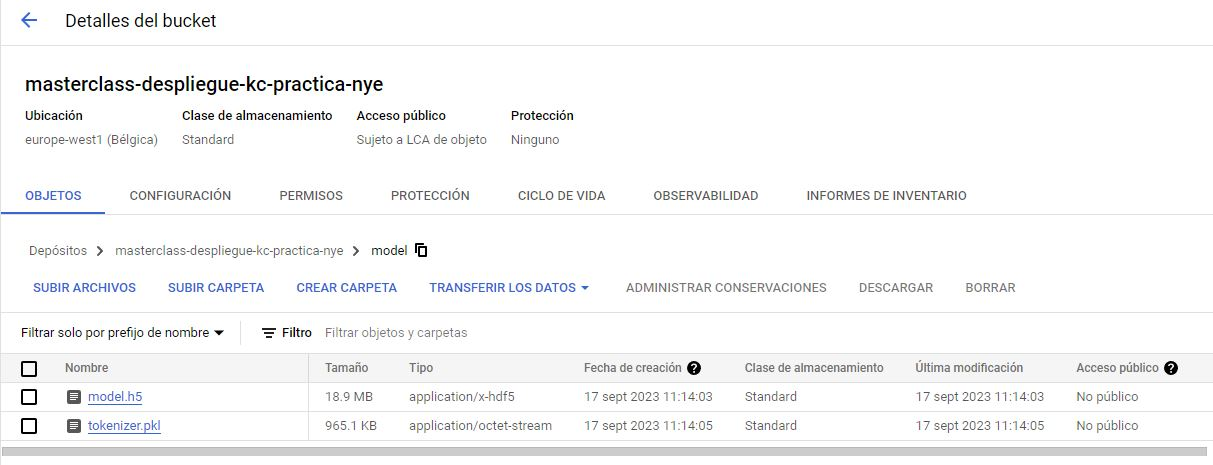

In [22]:
! gsutil cp -r transformed_data gs://$BUCKET_NAME

Copying file://transformed_data/train/part-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://transformed_data/train/part-00001-of-00002 [Content-Type=application/octet-stream]...
Copying file://transformed_data/eval/part-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://transformed_data/eval/part-00001-of-00002 [Content-Type=application/octet-stream]...
/
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://transformed_data/test/part-00000-of-00002 [Content-Type=application/octet-stream]...
Copying file://transformed_data/test/part-00001-of-00002 [Content-Type=application/octet-stream]...
\
Operation completed over 6 objects/2.3 MiB.                                      


Compruebo que están en el bucket los datos de Train:

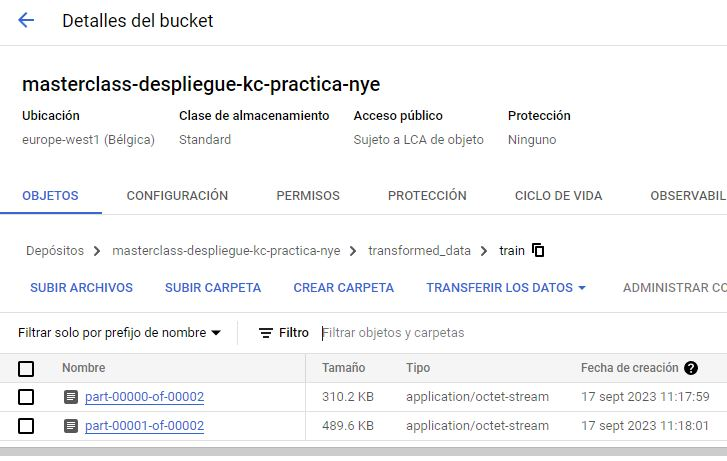

Hay que subir también los datos de entrada:

In [25]:
! gsutil cp -r data.json gs://$BUCKET_NAME

Copying file://data.json [Content-Type=application/json]...
|
Operation completed over 1 objects/2.6 MiB.                                      


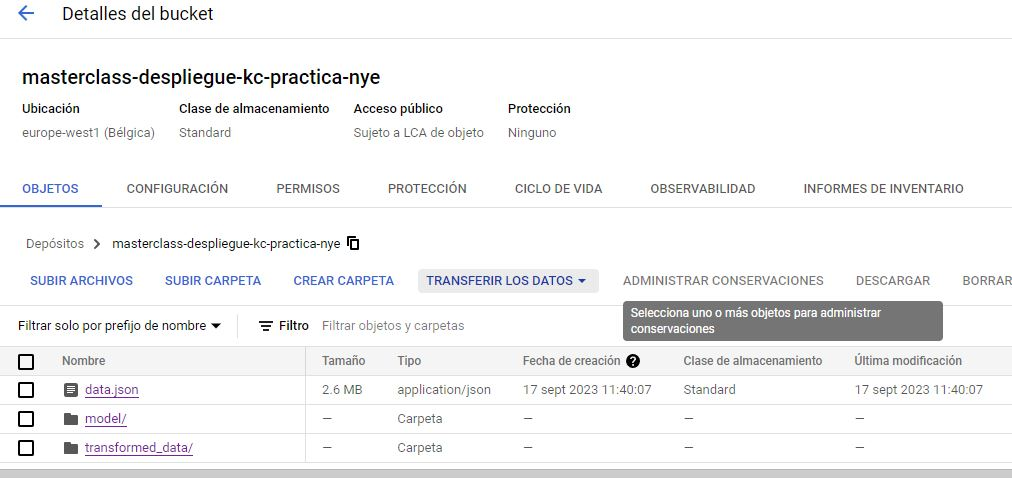

Establecemos el bucket y region de GCP sobre el que trabajaremos:

In [23]:
GCP_WORK_DIR = 'gs://' + BUCKET_NAME
GCP_REGION = "europe-west1"

### Validación Preprocess Train en Dataflow

Con el comando mostrado a continuación se valida la correcta generación de los datos de entrenamiento y validación en GCP con el servicio DataFlow.

**Nota.** Recuerda detener la celda una vez el trabajo te aparezca ejecutando en DataFlow.

In [26]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $GCP_WORK_DIR \
  --input $GCP_WORK_DIR/data.json \
  --output $GCP_WORK_DIR/transformed_data \
  --mode Train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmpj46_rufv']

INFO:apache_beam.runners.dataflow.dataflow_runner:Pipeline has additional dependencies to be installed in SDK worker container, consider using the SDK container image pre-building workflow to avoid repetitive installations. Learn more on https://cloud.google.com/dataflow/docs/guides/using-custom-containers#prebuild
INFO:root:Using provided Python SDK container image: gcr.io/cloud-dataflow/v1beta3/beam_python3.10_sdk:2.50.0
INFO:root:Python SDK container image set to "gcr.io/cloud-dataflow/v1beta3/beam_python3.10_sdk:2.50.0" for Docker environment
INFO:apache_beam.runners.portabi

Pongo Captura de la correcta ejecución de *PreprocessTrain* en DataFlow:

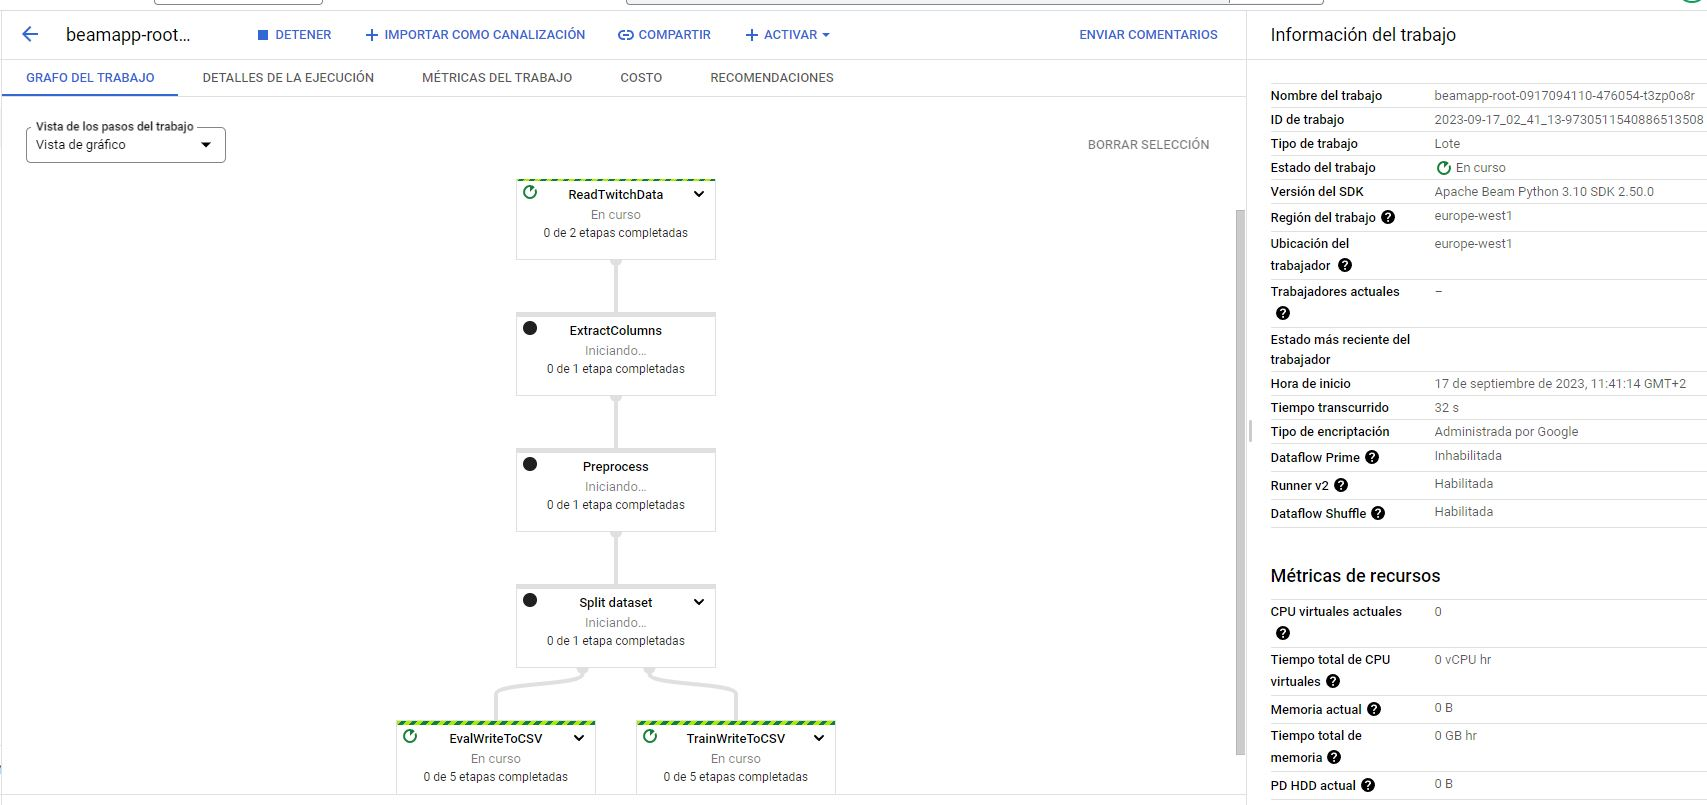

### Validación Preprocess Test en Dataflow

Con el comando mostrado a continuación se valida la correcta generación de los datos de test en GCP con el servicio DataFlow.

**Nota.** Recuerda detener la celda una vez el trabajo te aparezca ejecutando en DataFlow.

In [27]:
! python3 preprocess.py \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --work-dir $GCP_WORK_DIR \
  --input $GCP_WORK_DIR/data.json \
  --output $GCP_WORK_DIR/transformed_data \
  --mode Test

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
INFO:apache_beam.internal.gcp.auth:Setting socket default timeout to 60 seconds.
INFO:apache_beam.internal.gcp.auth:socket default timeout is 60.0 seconds.
INFO:apache_beam.runners.portability.stager:Executing command: ['/usr/bin/python3', 'setup.py', 'sdist', '--dist-dir', '/tmp/tmp5xj7j8sx']

INFO:apache_beam.runners.dataflow.dataflow_runner:Pipeline has additional dependencies to be installed in SDK worker container, consider using the SDK container image pre-building workflow to avoid repetitive installations. Learn more on https://cloud.google.com/dataflow/docs/guides/using-custom-containers#prebuild
INFO:root:Using provided Python SDK container image: gcr.io/cloud-dataflow/v1beta3/beam_python3.10_sdk:2.50.0
INFO:root:Python SDK container image set to "gcr.io/cloud-dataflow/v1beta3/beam_python3.10_sdk:2.50.0" for Docker environment
INFO:apache_beam.runners.portabi

Adjunto captura del gráfico de ejecución del *PreprocessTest* en DataFlow:

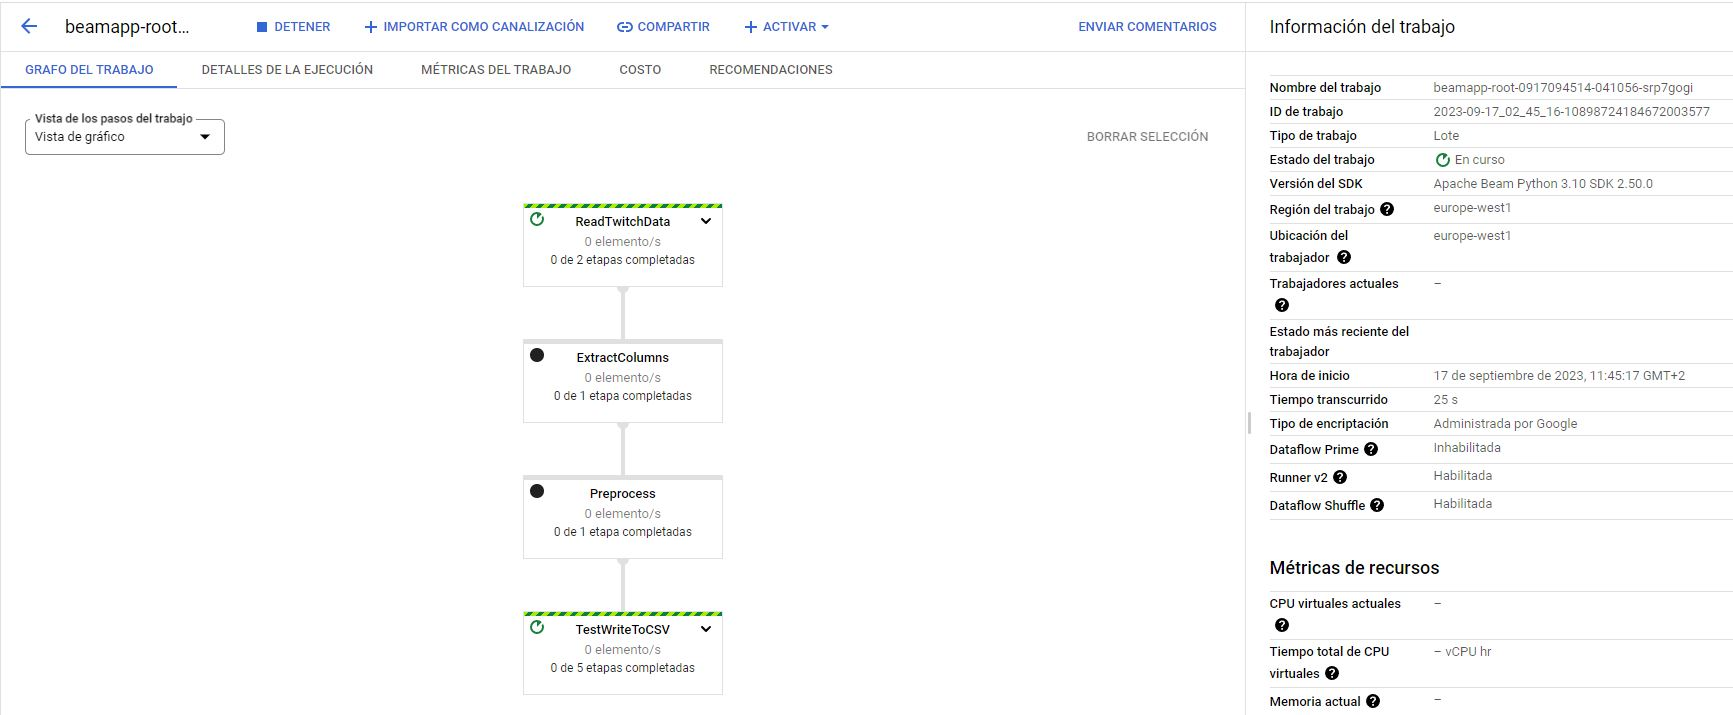

Omitimos el entrenamiento en la nube para no incurrir en costes innecesarios.

### Validación Predict en Dataflow

Con el comando mostrado a continuación se valida la predicción correcta de los datos de test usando los modelos generados en el comando anterior.

Generamos un timestamp para el almacenamiento de las inferencias en Google Cloud Storage.

In [28]:
from datetime import datetime

# current date and time
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

**Nota.** Recuerda detener la celda una vez el trabajo te aparezca ejecutando en DataFlow.

In [29]:
# For using sample models: --model-dir gs://$BUCKET_NAME/models/
! python3 predict.py \
  --work-dir $GCP_WORK_DIR \
  --model-dir $GCP_WORK_DIR/model/ \
  batch \
  --project $PROJECT_ID \
  --region $GCP_REGION \
  --runner DataflowRunner \
  --temp_location $GCP_WORK_DIR/beam-temp \
  --setup_file ./setup.py \
  --inputs-dir $GCP_WORK_DIR/transformed_data/test/part* \
  --outputs-dir $GCP_WORK_DIR/predictions/$TIMESTAMP

2023-09-17 09:54:00.465805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 09:54:01.620119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Namespace(work_dir='gs://masterclass-despliegue-kc-practica-nye', model_dir='gs://masterclass-despliegue-kc-practica-nye/model/', verb='batch', inputs_dir='gs://masterclass-despliegue-kc-practica-nye/transformed_data/test/part*', outputs_dir='gs://masterclass-despliegue-kc-practica-nye/predictions/2023-09-17_09-53-54')

Traceback (most recent call last):
  File "/content/batch/predict.py", line 180, in <module>
    run(args.model_dir, source, sink, beam_options)
  File "/content/batch/predict.py", line 112, in run
    with beam.Pipeline(options=beam_

Adjunto captura del Job iniciado en DataFlow para generar predicciones:

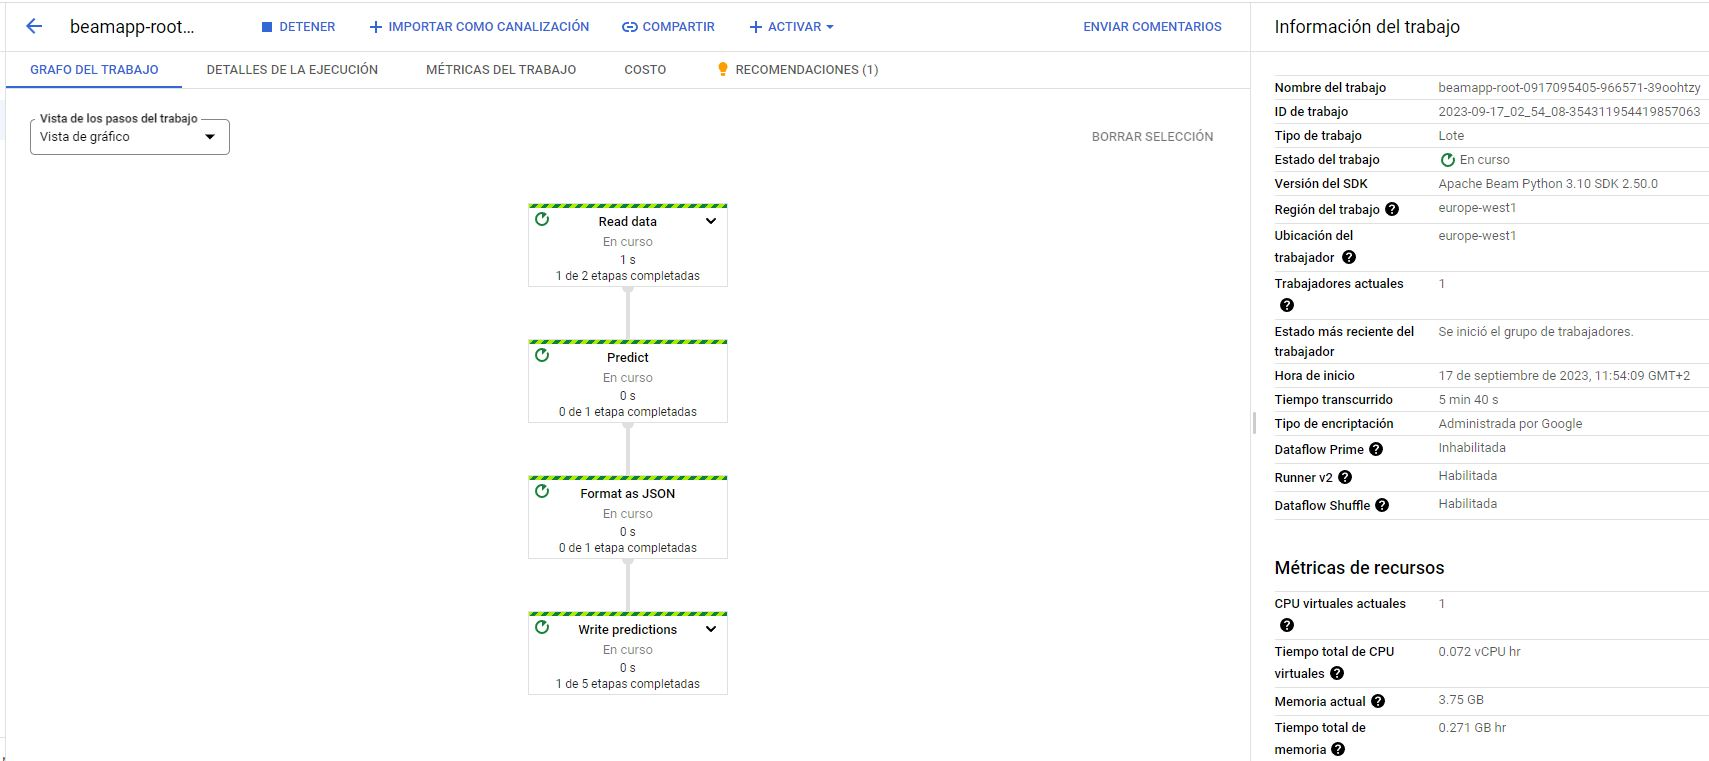

# Mensaje final

¡Muchas gracias por participar en este curso, espero que tanto las sesiones teóricas como la práctica te hayan resultado útiles. A lo largo de esta semana iréis recibiendo feedback personalizado sobre vuestras prácticas.

¡Muchas gracias y ánimo con el proyecto final!